In [ ]:
# Let's simulate the data of sequential composition for the fixed structure of the modules and compute E[Y(1)], as well as E[Y_{1}(1)] and E[Y_{2}(1)]. and see if expectations can be composed together. 

In [5]:
import argparse
import json
import os
import warnings
import sys
sys.path.append('../')

import pandas as pd
from sklearn.metrics import r2_score

from domains.samplers import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import *
warnings.filterwarnings('ignore')


import argparse
import json
import os
import warnings
import pandas as pd
from sklearn.metrics import r2_score
from domains.samplers import SyntheticDataSampler
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects


def parse_arguments(jupyter=False):
    parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
    parser.add_argument("--domain", type=str, default="synthetic_data", help="Domain")
    parser.add_argument("--biasing_covariate", type=str, default="feature_sum", help="Biasing covariate")
    parser.add_argument("--bias_strength", type=float, default=0, help="Bias strength")
    parser.add_argument("--scale", type=bool, default=False, help="Scale data")
    parser.add_argument("--num_modules", type=int, default=3, help="Number of modules")
    parser.add_argument("--num_feature_dimensions", type=int, default=1, help="Number of feature dimensions")
    parser.add_argument("--num_samples", type=int, default=1000, help="Number of samples")
    parser.add_argument("--module_function_type", type=str, default="quadratic", help="Module function type")
    parser.add_argument("--composition_type", type=str, default="parallel", help="Composition type")
    parser.add_argument("--resample", type=bool, default=True, help="Resample data")
    parser.add_argument("--seed", type=int, default=55, help="Seed for reproducibility")
    parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
    parser.add_argument("--data_dist", type=str, default="uniform", help="Data distribution")
    parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
    parser.add_argument("--split_type", type=str, default="iid", help="Split type")
    # hidden_dim
    parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
    # epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
    # batch_size
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    # output_dim
    parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
    # covariates_shared
    parser.add_argument("--covariates_shared", type=bool, default=True, help="Covariates shared")
    # model_class
    parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
    # run_env
    parser.add_argument("--run_env", type=str, default="unity", help="Run environment")
    # use_subset_features
    parser.add_argument("--use_subset_features", type=bool, default=False, help="Use subset features")
    # generate trees systematically for creating OOD data
    parser.add_argument("--systematic", type=bool, default=False, help="Generate trees systematically")


    if jupyter:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def setup_directories(args):
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains" if args.run_env == "local" else "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"
    main_dir = f"{base_dir}/{args.domain}"
    csv_path = f"{main_dir}/csvs/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    obs_data_path = f"{main_dir}/observational_data/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    scaler_path = f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/{args.split_type}/scalers"
    return main_dir, csv_path, obs_data_path, scaler_path

def simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path):
    if args.resample:
        sampler.simulate_data()
        sampler.create_observational_data(biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
        sampler.create_iid_ood_split(split_type=args.split_type)
        
    data = pd.read_csv(f"{csv_path}/{args.domain}_data_high_level_features.csv")
    df_sampled = pd.read_csv(f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/df_sampled.csv")
    
    return data, df_sampled

def load_train_test_qids(csv_path, args):
    with open(f"{csv_path}/{args.split_type}/train_test_split_qids.json", "r") as f:
        train_test_qids = json.load(f)
    train_qids, test_qids = train_test_qids["train"], train_test_qids["test"]
    return train_qids, test_qids

def load_train_test_data(csv_path, args, df_sampled):
    train_qids, test_qids = load_train_test_qids(csv_path, args)
    train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
    test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
    return train_df, test_df, train_qids, test_qids

def train_and_evaluate_model(model, train_df, test_df, covariates, treatment, outcome, epochs, batch_size, train_qids, test_qids):
    model, _, _ = train_model(model, train_df, covariates, treatment, outcome, epochs, batch_size)
    train_estimates = predict_model(model, train_df, covariates)
    test_estimates = predict_model(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids):
    model = train_catenets(train_df, covariates, treatment, outcome)
    train_estimates = predict_catenets(model, train_df, covariates)
    test_estimates = predict_catenets(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def calculate_metrics(gt_effects, estimated_effects):
    pehe_score = pehe(gt_effects, estimated_effects)
    r2_score_val = r2_score(gt_effects, estimated_effects)
    return pehe_score, r2_score_val

def decompose_module_errors(module_csvs, num_modules):
    module_dfs = {}
    module_wise_pehe = []
    cov = {}
    print(module_csvs.keys())

    for module_file, module_csv in module_csvs.items():
        module_id = int(module_file.split("_")[-1])
        print(f"Module {module_id}")
        module_dfs[module_id] = module_csv
        pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
        a = module_csv['ground_truth_effect']
        b = module_csv['estimated_effect']
        module_wise_pehe.append(pehe_score)
        cov[module_id] = a - b

    total_cov = []
    for i in range(1, num_modules + 1):
        for j in range(1, num_modules + 1):
            if i != j:
                total_cov.append(np.mean(cov[i] * cov[j]))

    return  sum(module_wise_pehe), sum(total_cov)


def process_shared_covariates_row_wise(train_df, test_df, args):
    num_modules = [col for col in train_df.columns if col.startswith('num_module_')]
    if args.covariates_shared and args.composition_type == "parallel":
        def process_row(row):
            # Find non-zero modules for this row
            num_modules = [col for col in row.index if col.startswith('num_module_')]
            non_zero_modules = [int(col.split('_')[-1]) for col in num_modules if row[col] != 0]
            first_module = non_zero_modules[0]
            first_module_features = [col for col in row.index if col.startswith(f'module_{first_module}_feature_')]
            if not non_zero_modules:
                raise ValueError(f"No non-zero modules found for row with query_id {row['query_id']}")
            
            # Create a new row with renamed features
            new_row = {}
            for feature in first_module_features:
                feature_id = int(feature.split('_')[-1])
                new_row[f'feature_{feature_id}'] = row[feature]
            
            # Add other necessary columns
            for col in ['query_id', 'treatment_id', 'tree_depth', 'query_output'] + num_modules:
                new_row[col] = row[col]
            
            return pd.Series(new_row)

        # don't include header row
        train_df_processed = train_df.apply(process_row, axis=1)
        test_df_processed = test_df.apply(process_row, axis=1)
        print(f"Train data shape: {train_df_processed.shape}")
        print(f"Test data shape: {test_df_processed.shape}")
        
        
        # Ensure consistent column ordering
        columns_order = [col for col in train_df_processed.columns if col.startswith('feature_')] + ['query_id', 'treatment_id', 'tree_depth', 'query_output'] + num_modules
        train_df_processed = train_df_processed[columns_order]
        test_df_processed = test_df_processed[columns_order]
        
        return train_df_processed, test_df_processed
    else:
        # If covariates are not shared, return the original dataframes
        return train_df, test_df

def combine_model_effects(gt_effects, model_effects, additive_combined_df):
    """
    Combine ground truth effects with estimated effects from all models into a single DataFrame.
    
    :param gt_effects: Dictionary of ground truth effects
    :param model_effects: Dictionary of estimated effects for each model
    :param additive_combined_df: DataFrame with additive model results
    :return: Combined DataFrame with effects from all models
    """
    # Start with ground truth effects
    combined_df = pd.DataFrame({
        'query_id': gt_effects.keys(),
        'ground_truth_effect': gt_effects.values()
    })
    
    # Add effects from each model
    for model_name, effects in model_effects.items():
        combined_df[f'{model_name}_effect'] = [effects[qid] for qid in combined_df['query_id']]
    
    # Add effects from the additive model
    additive_effects = additive_combined_df.set_index('query_id')['estimated_effect']
    additive_gt_effects = additive_combined_df.set_index('query_id')['ground_truth_effect']
    combined_df['Additive_effect'] = combined_df['query_id'].map(additive_effects)
    combined_df['Additive_gt_effect'] = combined_df['query_id'].map(additive_gt_effects)
    
    return combined_df


args = parse_arguments()
print(args)
main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
module_function_types = ["quadratic"] * args.num_modules
# module_function_types = ["quadratic"] * args.num_modules
sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env)

# first sample the data and prepare it
data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path)

# Load train and test qids
train_qids, test_qids = load_train_test_qids(csv_path, args)

# Scale data
if args.scale:
    create_module_scalers(csv_path, obs_data_path, scaler_path, train_qids, args.bias_strength)
    data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)

# Load train and test data
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)
covariates = [x for x in train_df.columns if "feature" in x]

Namespace(batch_size=64, bias_strength=0, biasing_covariate='feature_sum', composition_type='parallel', covariates_shared=True, data_dist='uniform', domain='synthetic_data', epochs=100, fixed_structure=True, heterogeneity=1.0, hidden_dim=64, module_function_type='quadratic', num_feature_dimensions=1, num_modules=3, num_samples=1000, output_dim=1, resample=True, run_env='unity', scale=False, seed=55, split_type='iid', systematic=False, underlying_model_class='MLP', use_subset_features=False)
num_modules:  3
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Resampling data
Generating input trees
Generating input trees
Number of input trees generated: 1000
Simulating potential outcomes for treatment 0
Simulating potential outcomes for treatment 1
Writing CSV data to files for each module.
train depths:  []
test depths:  [3]
Train data shape: (956, 8)
Test data shape: (44, 8)


In [11]:

# covariates = [x for x in train_df.columns if "module_1_feature" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
if args.systematic:
    covariates += [x for x in train_df.columns if "num" in x]

print(f"Training data shape: {train_df.shape}")
print("Covaariates: ", covariates)
treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)


model_effects_train = {}
model_effects_test = {}

input_dim = len(covariates)
models = {
    "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
    "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
}

results = {}
for model_name, model_class in models.items():
    print(f"Training {model_name} Model")
    if model_name == "Baseline":
        model = model_class(input_dim + 1, args.hidden_dim, args.output_dim)
    else:
        model = model_class(input_dim + 1, args.hidden_dim, args.output_dim, args.num_modules)
    
    estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
        model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
    )
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
    model_effects_train[model_name] = estimated_effects_train
    model_effects_test[model_name] = estimated_effects_test


# Catenets
print("Training Catenets Model")
estimated_effects_train, estimated_effects_test = train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids)
gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
results["Catenets_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
results["Catenets_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
# Add Catenets effects
model_effects_train["Catenets"] = estimated_effects_train
model_effects_test["Catenets"] = estimated_effects_test
    
print("Training Additive Model")
additive_combined_train_df, additive_combined_test_df, module_csvs_train, module_csvs_test = get_additive_model_effects(
    csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
    batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path, bias_strength=args.bias_strength
)
# print(additive_combined_train_df.head())
# print(additive_combined_test_df.head())
results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"])

module_pehe_sum_train, module_cov_train = decompose_module_errors(module_csvs_train, args.num_modules)
module_pehe_sum_test, module_cov_test = decompose_module_errors(module_csvs_test, args.num_modules)
results["Module_PEHE_decomposition_test"] = module_pehe_sum_test, module_cov_test
results["Module_PEHE_decomposition_train"] = module_pehe_sum_train, module_cov_train

# Save results and CSVs
results_path = f"{main_dir}/results/systematic_{args.systematic}/results_{args.data_dist}_{args.composition_type}_covariates_shared_{args.covariates_shared}_use_subset_features_{args.use_subset_features}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)

results_csv_folder = f"{results_path}/csvs_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and modulbe_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs_test.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

# Create combined DataFrames
combined_df_train = combine_model_effects(gt_effects_train, model_effects_train, additive_combined_train_df)
combined_df_test = combine_model_effects(gt_effects_test, model_effects_test, additive_combined_test_df)

# Save combined DataFrames
combined_df_train.to_csv(f"{results_csv_folder}/combined_effects_train.csv", index=False)
combined_df_test.to_csv(f"{results_csv_folder}/combined_effects_test.csv", index=False)
print(combined_df_train.head())
print(combined_df_test.head())

 
print(results)
print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

Training data shape: (956, 8)
Covaariates:  ['feature_0']
Training Baseline Model
Training the model on cpu
(956, 2)
Training MoE Model
Training the model on cpu
(956, 2)


KeyboardInterrupt: 

# Expectation Analysis for Different Composition Models 

<AxesSubplot:xlabel='query_output', ylabel='Count'>

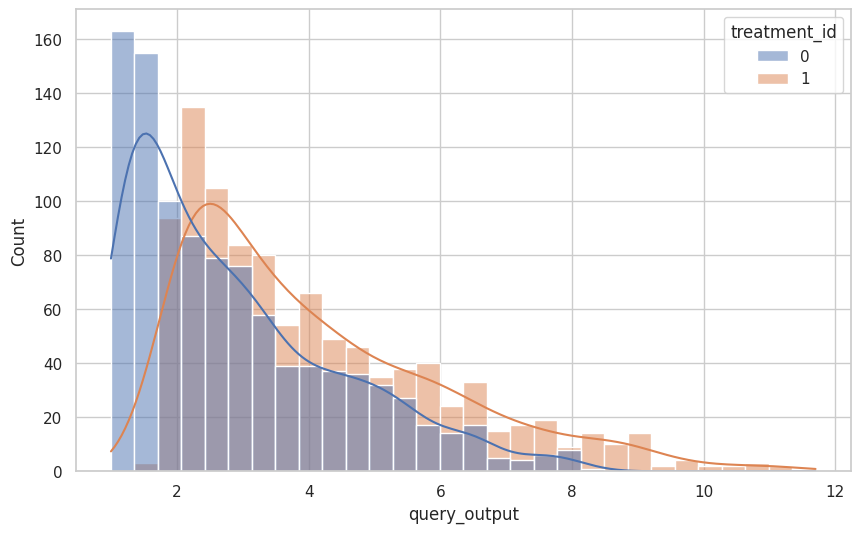

In [2]:
Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])

# plot the distribution of the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, x='query_output', hue='treatment_id', bins=30, kde=True)

<AxesSubplot:xlabel='query_output', ylabel='Count'>

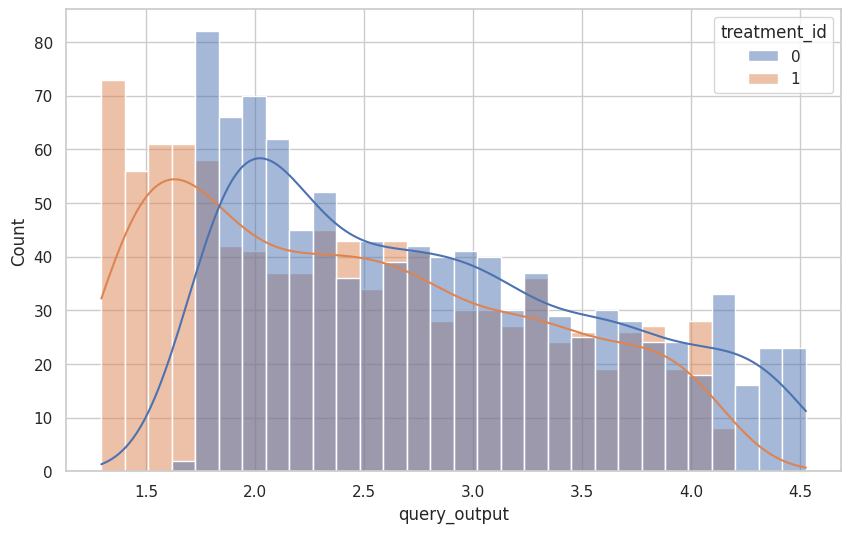

In [6]:
Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])

# plot the distribution of the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data, x='query_output', hue='treatment_id', bins=30, kde=True)

In [3]:
E_Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
E_Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])
print(E_Y_1, E_Y_0)

4.0939392352073565 2.854076866597079


In [7]:
E_Y_1 = np.mean(data[data['treatment_id'] == 1]['query_output'])
E_Y_0 = np.mean(data[data['treatment_id'] == 0]['query_output'])
print(E_Y_1, E_Y_0)

2.4475545720506675 2.819419872355089


In [4]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 2.4612038224109036, E[Y_0] = 1.7833501869985466
module_2 E[Y_1] = 2.575437712508174, E[Y_0] = 1.8960972951431871
module_3 E[Y_1] = 2.1139307934398075, E[Y_0] = 1.9090269227922814
Sum of E[Y_1] = 7.150572328358885, E[Y_0] = 5.588474404934015


In [8]:
sum_e_1 = 0
sum_e_0 = 0
for i in range(args.num_modules):
    # print(f"Module {i}")
    data_treatment_1 = data[(data['treatment_id'] == 1) & (data[f'num_module_{i+1}'] > 0)]
    data_treatment_0 = data[(data['treatment_id'] == 0) & (data[f'num_module_{i+1}'] > 0)]
    E_Y_1_i = np.mean(data_treatment_1[f'module_{i+1}_output'])
    E_Y_0_i = np.mean(data_treatment_0[f'module_{i+1}_output'])
    print(f"module_{i+1} E[Y_1] = {E_Y_1_i}, E[Y_0] = {E_Y_0_i}")
    sum_e_1 += E_Y_1_i
    sum_e_0 += E_Y_0_i
print(f"Sum of E[Y_1] = {sum_e_1}, E[Y_0] = {sum_e_0}")

module_1 E[Y_1] = 0.7511988074220146, E[Y_0] = 1.2141302990399152
module_2 E[Y_1] = 0.8987803679252591, E[Y_0] = 0.6763471384742122
module_3 E[Y_1] = 0.7975753967033942, E[Y_0] = 0.9289424348409615
Sum of E[Y_1] = 2.447554572050668, E[Y_0] = 2.819419872355089


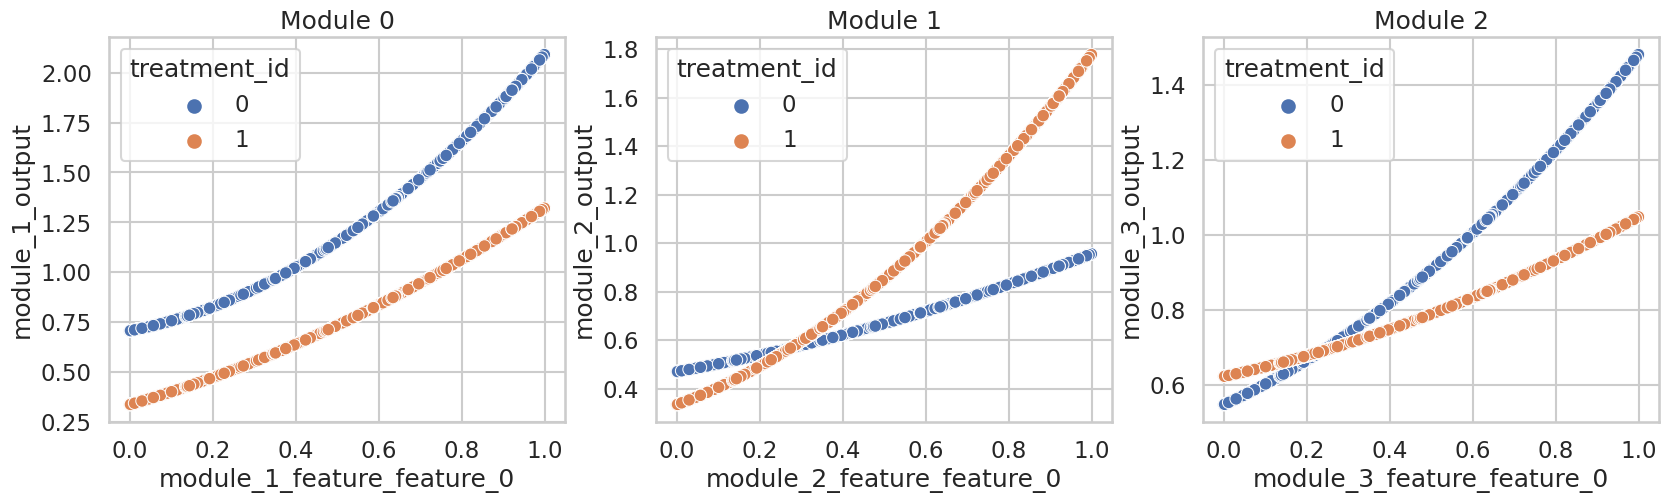

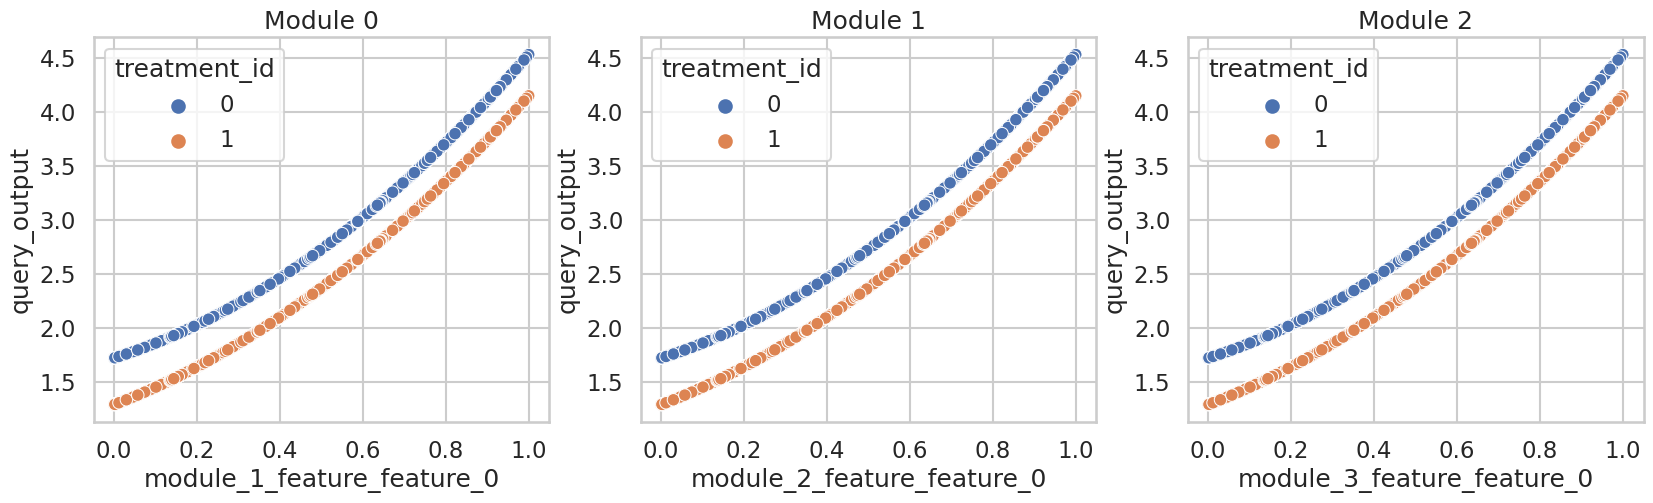

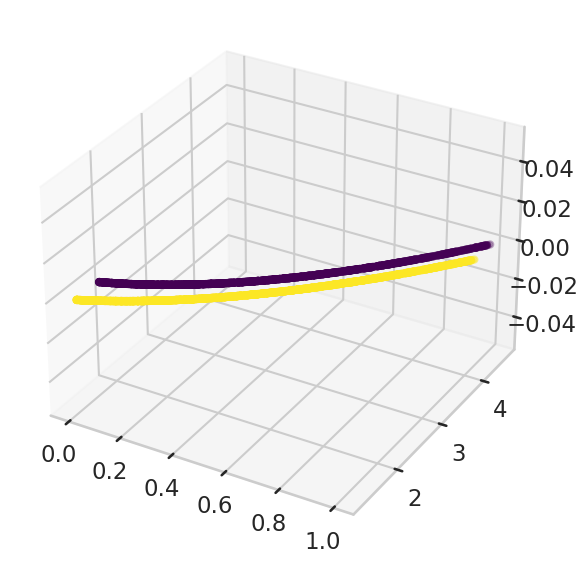

In [10]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 3
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



In [3]:
for module_file, module_csv in module_csvs_test.items():
    module_id = int(module_file.split("_")[-1])
    print(f"Module {module_id}")
    pehe_score = pehe(module_csv['ground_truth_effect'], module_csv['estimated_effect'])
    print(f"PEHE: {pehe_score}")
    print(f"R2 Score: {r2_score(module_csv['ground_truth_effect'], module_csv['estimated_effect'])}")
    print("\n")

Module 1
PEHE: 0.08040142040609795
R2 Score: 0.06896162919603122


Module 2
PEHE: 0.007862329251598596
R2 Score: 0.9886157298288518


Module 3
PEHE: 0.01019560942863159
R2 Score: 0.9766213891288087


Module 4
PEHE: 0.013694837207611596
R2 Score: -3.2505638712174276


Module 5
PEHE: 0.0002946262653347609
R2 Score: 0.9990349233445999


Module 6
PEHE: 0.04693336018827671
R2 Score: -0.37112844645880405




In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X = data[["feature_0"]].values
# T = data[treatment].values
# Y = data[outcome].values
# Y_module = data[[f"module_{i}_output" for i in range(1, args.num_modules + 1)]].values
# X_T = np.concatenate([X, T.reshape(-1, 1)], axis=1)
# X_T = torch.tensor(X_T, dtype=torch.float32).to(device)
# expert_outputs = torch.stack([expert(X_T) for expert in model.experts], dim=1)
# gate_outputs = model.gate(X_T)
# expert_gate_multiplication = expert_outputs.squeeze(-1) * gate_outputs
# print(expert_outputs.shape, Y_module.shape, expert_gate_multiplication.shape)


In [13]:
# for i in range(6):
#     data["expert_output_" + str(i)] = expert_gate_multiplication[:, i].detach().cpu().numpy()

covariates

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

In [6]:
# data["final_output"] = final_output.squeeze(0).detach().cpu().numpy()

# # scatter plot for final output and query output
# plt.figure(figsize=(10, 10))
# sns.scatterplot(x="query_output", y="final_output", data=data)
# plt.xlabel("Query Output")
# plt.ylabel("Final Output")
# plt.title("Final Output vs Query Output")
# plt.show()

<AxesSubplot:xlabel='feature_0', ylabel='query_output'>

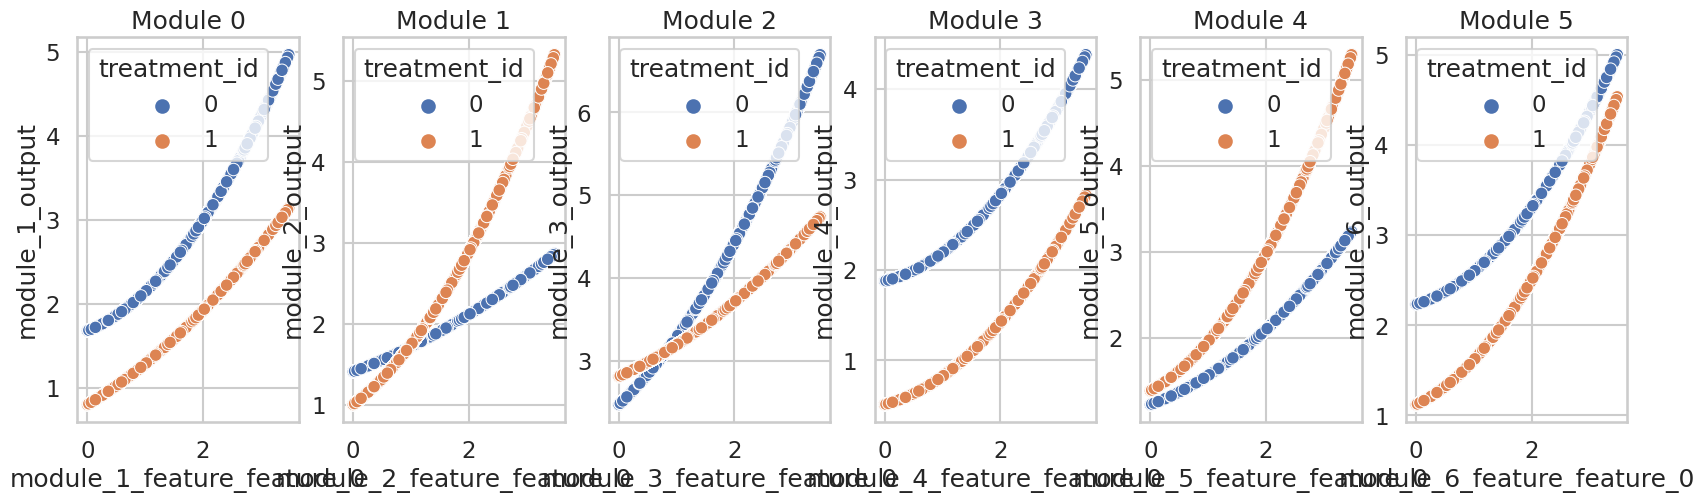

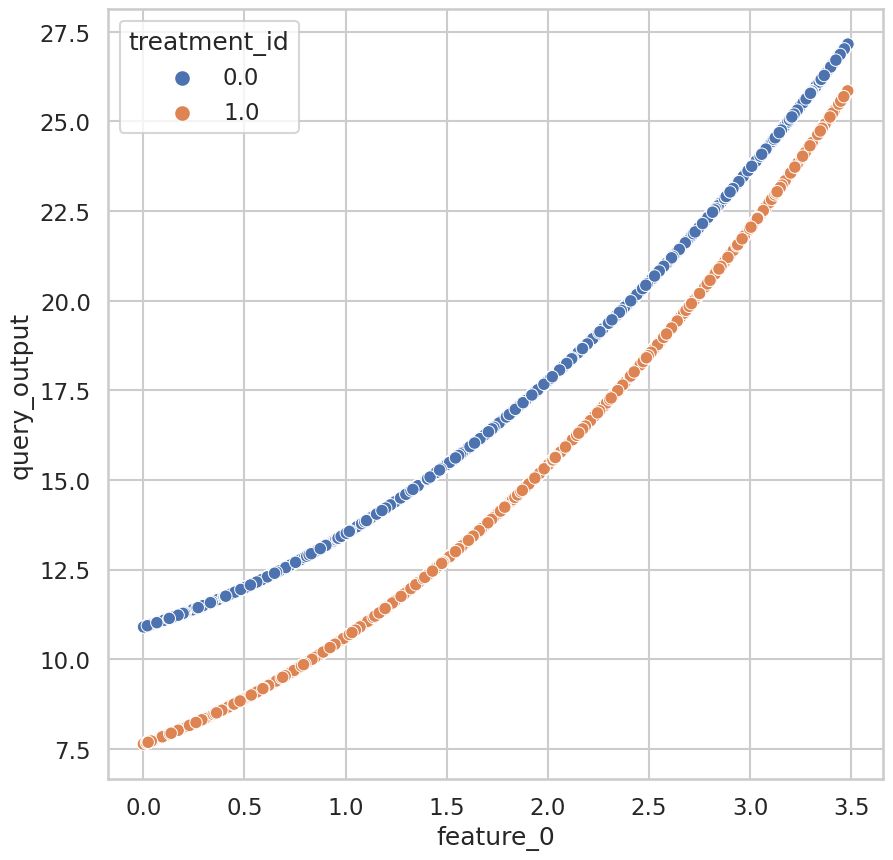

In [ ]:
# plot distribution of the covariates for train df with treatment id
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.kdeplot(data=train_df, x="feature_0", hue="treatment_id", label="Train", color="blue", ax=ax[0])
ax[0].set_title("Train Distribution")
sns.kdeplot(data=test_df, x="feature_0", hue="treatment_id", label="Test", color="red", ax=ax[1])
ax[1].set_title("Test Distribution")


plt.title("Train Distribution")
plt.show()

In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")


plt.title("Train Distribution")
plt.show()





In [ ]:
# plot distribution of the output for train and test df in the same plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(train_df["query_output"], ax=ax[0], kde=True)
ax[0].set_title("Train Distribution")
sns.histplot(test_df["query_output"], ax=ax[1], kde=True)
ax[1].set_title("Test Distribution")
plt.show()

# plot distribution of the output for train and test df in the same plot
# scale the distribution by dividing by the number of samples
sns.kdeplot(train_df["query_output"], label="Train", color="blue")
sns.kdeplot(test_df["query_output"], label="Test", color="red")
plt.title("Train Distribution")
plt.show()





# Results Analysis

In [22]:
# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)



results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here
additive_combined_test_df.to_csv(f"{results_csv_folder}/additive_combined_test_df.csv", index=False)
for module_file, module_csv in module_csvs.items():
    module_csv.to_csv(f"{results_csv_folder}/{module_file}.csv", index=False)

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")
print("Done!")

2024-09-22 03:07:47.829116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_uniform_quadratic_parallel_covariates_shared_False_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs
Done!


In [23]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [24]:
combined_df_test

,ground_truth_effect,estimated_effect
0,-0.293698,-0.311285
1,-0.641127,-0.642452
2,-0.612727,-0.604818
3,0.239012,0.246677
4,-0.717167,-0.693429
...,...,...
162,-0.719175,-0.764137
163,0.595639,0.640840
164,1.285423,1.451030
165,-0.269334,-0.208952


In [16]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
# hl_filepath = f"{results_csv_folder}/combined_df_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}.csv"
hl_filepath = f"{results_csv_folder}/additive_combined_test_df.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns

pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


KeyError: 'ground_truth_effect_baseline'

# Data Analysis

# Data baseline model 

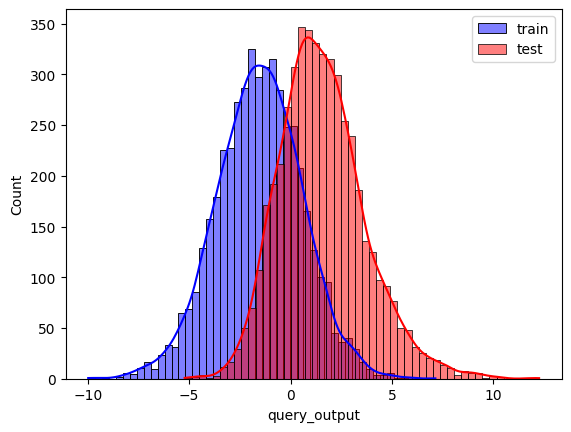

In [5]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

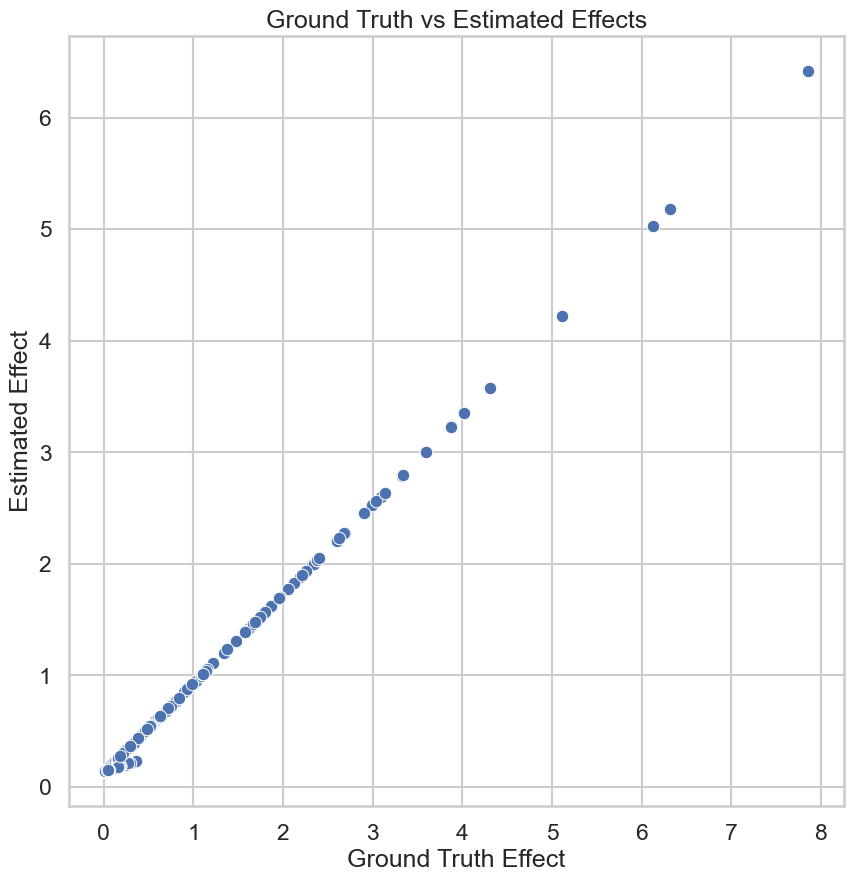

In [55]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

